In [1]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.4 MB/s 


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/SartoriousScripts')

In [5]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from skimage.morphology import (
    square, dilation,
    remove_small_holes, remove_small_objects)
from skimage.segmentation import watershed
from skimage import measure
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf

from src.models_resnet import ResUNet34, ResUNet50
from src.metrics import average_precision

In [6]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/SartoriousModels/dsb2018_ResUNet34_res_480x640_batch_size_8')

In [8]:
# load model

model_shape = (480, 640)

model_params = {
    'input_shape': model_shape + (1,),
    'num_out_filters': 2
}

model = ResUNet50(**model_params)

load_path = '/content/drive/MyDrive/SartoriousDatasets/supervised/checkpoints/dsb2018V2_ResUNet50_res_480x640_batch_size_8_augs'
latest_ckpt = tf.train.latest_checkpoint(load_path)

print(f'Latest ckpt: {latest_ckpt}')

status = model.load_weights(latest_ckpt)
status.assert_existing_objects_matched()

model.summary()

Latest ckpt: /content/drive/MyDrive/SartoriousDatasets/supervised/checkpoints/dsb2018V2_ResUNet50_res_480x640_batch_size_8_augs/model_35
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 init_conv (Conv2D)             (None, 240, 320, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 init_bn (BatchNormalization)   (None, 240, 320, 64  256

In [9]:
data_dir = Path('/content/drive/MyDrive/SartoriousDatasets/supervised/val')

image_dir = data_dir/'images'
mask_dir = data_dir/'dsb2018_masks_v2'
instance_dir = data_dir/'instances'

image_paths = list(image_dir.glob('*.png'))
mask_paths = [mask_dir/(str(Path(str(p).replace('.png', '_dsb2018_mask.tif')).stem) + '.tif')
              for p in image_paths]
instance_paths = [instance_dir/(str(Path(str(p).replace('.png', '_instance.tif')).stem) + '.tif')
                  for p in image_paths]

image_paths[0], mask_paths[0], instance_paths[0]

(PosixPath('/content/drive/MyDrive/SartoriousDatasets/supervised/val/images/0030fd0e6378.png'),
 PosixPath('/content/drive/MyDrive/SartoriousDatasets/supervised/val/dsb2018_masks_v2/0030fd0e6378_dsb2018_mask.tif'),
 PosixPath('/content/drive/MyDrive/SartoriousDatasets/supervised/val/instances/0030fd0e6378_instance.tif'))

In [10]:
# get cell types to find metric on different types

data_dir = Path('/content/drive/MyDrive/SartoriousDatasets/Initial')
train_csv = data_dir/'train.csv'

train_df = pd.read_csv(train_csv)

cell_types = [train_df[train_df['id'] == Path(p).stem].cell_type.values[0] for p in image_paths]
cell_types = np.array(cell_types)

cell_idxes_astro = np.where(cell_types == 'astro')[0]
cell_idxes_cort = np.where(cell_types == 'cort')[0]
cell_idxes_shsy5y = np.where(cell_types =='shsy5y')[0]

len(cell_idxes_astro) + len(cell_idxes_cort) + len(cell_idxes_shsy5y)

121

In [46]:
def preprocess(img, h=480, w=640):
    img = img.astype(np.float32) / 255.0
    img = cv2.resize(img, (w, h))
    
    return img


def postprocess_multichannel(logits, h=520, w=704):
    mask = tf.nn.sigmoid(logits[..., 0]).numpy()
    border = tf.nn.sigmoid(logits[..., 1]).numpy()

    mask[mask > 0.5] = 1
    mask[mask != 1] = 0

    border[border > 0.5] = 1
    border[border != 1] = 0

    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    border = cv2.resize(border, (w, h), interpolation=cv2.INTER_NEAREST)

    return np.stack([mask, border], axis=-1)

    mask = measure.label(mask, background=0, connectivity=2)
    props = measure.regionprops(mask)

    for i in range(len(props)):
        if props[i].area < 20:
            mask[mask == (i + 1)] = 0
    mask = measure.label(mask, background=0, connectivity=2)

    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

    return mask

  
def postprocess_multichannelv2(logits, h=520, w=704):
    mask = tf.nn.sigmoid(logits[..., 0]).numpy()

    mask[mask > 0.5] = 1
    mask[mask != 1] = 0
    mask = mask.astype(np.uint8)

    # mask = remove_small_holes(mask, 500)
    # mask = remove_small_objects(mask, 5)

    # m2 = mask.copy()

    # dist_transform = cv2.distanceTransform(m2.copy().astype(np.uint8), cv2.DIST_L2, 3)

    # # get sure foreground area: region near to center of object
    # fg_val, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

    # # get sure background area: region much away from the object
    # sure_bg = cv2.dilate(m2.astype(np.uint8), np.ones((3,3),np.uint8))

    # borders = cv2.subtract(sure_bg, np.uint8(sure_fg))

    # n_markers, markers1 = cv2.connectedComponents(np.uint8(sure_fg))
    # markers1 = remove_small_objects(markers1, min_size = 100)

    # markers2 = markers1 + 1
    # markers2[borders == 1] = 0

    # instance = watershed(m2.copy(), markers2)

    dist_mask = cv2.distanceTransform(mask.astype(np.uint8),cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_mask,0.3*dist_mask.max(),1,0)
    ret, markers = cv2.connectedComponents(sure_fg.astype(np.uint8))

    instance = watershed(mask, markers, mask=mask)

    props = measure.regionprops(instance)
    for i in range(len(props)):
        if props[i].area < 5:
            instance[instance == (i + 1)] = 0
    instance = measure.label(instance, background=0, connectivity=2)
    
    instance = cv2.resize(instance, (w, h), interpolation=cv2.INTER_NEAREST)

    return instance


def postprocess_categorical(logits, h=520, w=704):
    mask = tf.nn.softmax(logits, axis=-1)
    mask = tf.argmax(mask, axis=-1).numpy()

    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

    instance = measure.label(mask, background=0)

    return instance

In [13]:
# gt
instances = np.stack([np.array(Image.open(p)) for p in instance_paths]).astype(np.float32)
masks = np.stack([np.array(Image.open(p)) for p in mask_paths]).astype(np.float32)

In [47]:
# pred
prediction = []

for img_p in tqdm(image_paths):
    image = np.array(Image.open(img_p))
    image = preprocess(image)
    
    logits = model(image[None, :, :, None], training=False).numpy().squeeze()
    
    instance = postprocess_multichannelv2(logits)
    # instance = postprocess_categorical(logits)
    
    prediction.append(instance)
    
prediction = np.stack(prediction).astype(np.float32)

instances.shape, prediction.shape

100%|██████████| 121/121 [04:38<00:00,  2.30s/it]


((121, 520, 704), (121, 520, 704))

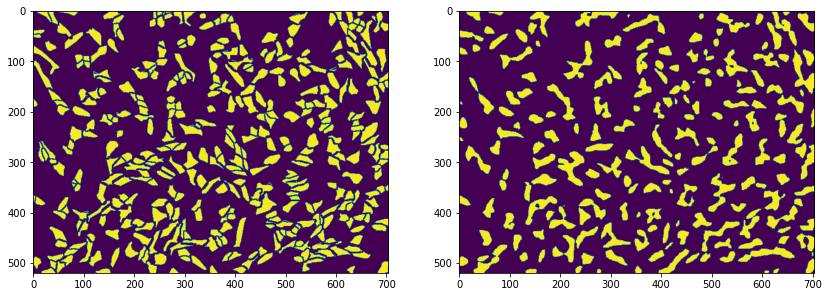

In [36]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(14, 8)

axes[0].imshow(masks[0][..., 0])
axes[1].imshow(prediction[0][..., 0])

In [ ]:
from src.metrics import iou

In [ ]:
# 0.33 - astro; 0.108
# 0.37 - shsy5y; 0.15
# 0.375 - cort; 0.14

iou(masks[cell_idxes_cort], prediction[cell_idxes_cort], channel=1, from_logits=False)

<tf.Tensor: shape=(), dtype=float32, numpy=0.13770306>

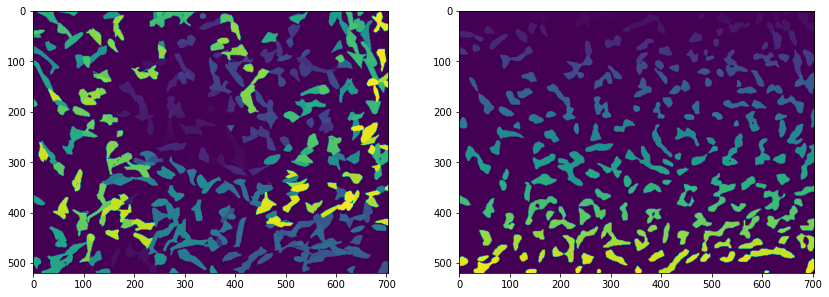

In [48]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(14, 8)

axes[0].imshow(instances[0])
axes[1].imshow(prediction[0])

In [49]:
metric_astro = average_precision(tf.cast(instances[cell_idxes_astro, ..., None], tf.float32),
                                 tf.cast(prediction[cell_idxes_astro, ..., None], tf.float32))
metric_cort = average_precision(tf.cast(instances[cell_idxes_cort, ..., None], tf.float32),
                                tf.cast(prediction[cell_idxes_cort, ..., None], tf.float32))
metric_shsy5y = average_precision(tf.cast(instances[cell_idxes_shsy5y, ..., None], tf.float32),
                                  tf.cast(prediction[cell_idxes_shsy5y, ..., None], tf.float32))
metric = average_precision(tf.cast(instances[..., None], tf.float32),
                           tf.cast(prediction[..., None], tf.float32))

In [50]:
print(f'Astro: {metric_astro}\nCort: {metric_cort}\nShsy5y: {metric_shsy5y}\n'
      f'Overall: {metric}')

Astro: 0.13055168092250824
Cort: 0.2603212893009186
Shsy5y: 0.13637672364711761
Overall: 0.20068252086639404


In [ ]:
print(f'Astro: {metric_astro}\nCort: {metric_cort}\nShsy5y: {metric_shsy5y}\n'
      f'Overall: {metric}')

Astro: 0.06068778783082962
Cort: 0.278164267539978
Shsy5y: 0.13081328570842743
Overall: 0.1936827301979065


In [ ]:
# Categorical; Dice + SCCE (convert borders to bg class (0))
#   Astro: 0.09
#   Cort: 0.42
#   Shsy5y: 0.13
#   Overall: 0.274
# MultiChannel; Dice + CE 
#   Astro: 0.0727541595697403
#   Cort: 0.45176148414611816
#   Shsy5y: 0.1140083372592926
#   Overall: 0.28379008173942566
# Categorical; Dice + SCCE (borders == 2 (no changes))
#   Astro: 0.13380633294582367
#   Cort: 0.27608007192611694
#   Shsy5y: 0.14439788460731506
#   Overall: 0.2117720991373062

In [ ]:
# save full model for submission

models_dir = Path('/content/drive/MyDrive/SartoriousModels')

model_path = models_dir/'dsb2018_ResUNet34_res_480x640_batch_size_8'

model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SartoriousModels/dsb2018_ResUNet34_res_480x640_batch_size_8/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
